# Summary

* Name: `dissipation-theory--Study-6.ipynb`
* Author: John A. Marohn
* Date: 2023-09-30
* Continued from: `dissipation-theory--Study-5.ipynb`
* Continued to: `dissipation-theory--Study-7.ipynb`
* Reproduce the friction $\gamma_{\parallel}$ versus charge density $\rho$ plots in Lekkala2013 Figure 7(b) using the functions in `dissipationtheory.dissipation.py`.  The computation is carried out over 40 charge densities, for 4 charge mobilities, and using Model I and Model II in the paper.  The computation in done two ways -- in pure Python and in `numba`-compiled Python.  The computation takes approximately 2.4 min in pure Python and 0.6 s in `numba`-compiled Python.

# Preliminaries

In [ ]:
from dissipationtheory.constants import ureg, epsilon0, qe
from dissipationtheory.capacitance import CsphereOverSemi

from dissipationtheory.dissipation import CantileverModel, SampleModel1,  SampleModel2
from dissipationtheory.dissipation import theta1norm, theta2norm, gamma_parallel
from dissipationtheory.dissipation import gamma_parallel_approx

from dissipationtheory.dissipation import CantileverModelJit, SampleModel1Jit, SampleModel2Jit
from dissipationtheory.dissipation import theta1norm_jit, theta2norm_jit, gamma_parallel_jit

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
THIS = 'dissipation-theory--Study-6'

# Read in digitized data

In [3]:
keys = ['1.5e-01','4.0e-07','2.7e-10','6.0e-14']

names = ['Lekkala2013--Fig7b--1.5e-01.csv', 
         'Lekkala2013--Fig7b--4.0e-07.csv',
         'Lekkala2013--Fig7b--2.7e-10.csv',
         'Lekkala2013--Fig7b--6.0e-14.csv']

Figure7b_original = {}
for key, name in zip(keys, names):
    Figure7b_original[key] = pd.read_csv(name, names=['rho', 'gamma'])

# Run the simulations (pure Python)

## Sample 1

In [4]:
sample1 = SampleModel1(

        cantilever = CantileverModel(
            f_c = ureg.Quantity(81, 'kHz'), 
            V_ts = ureg.Quantity(3, 'V'), 
            R = ureg.Quantity(80, 'nm'), 
            d = ureg.Quantity(300, 'nm')),
        h_s = ureg.Quantity(1e6, 'nm'),
        epsilon_s = ureg.Quantity(complex(11.9, -0.05), ''),
        mu = ureg.Quantity(2.7e-10, 'm^2/(V s)'),
        rho = ureg.Quantity(1e21, '1/m^3'),
        epsilon_d = ureg.Quantity(complex(11.9, -0.05), ''),
        z_r = ureg.Quantity(300, 'nm')
    )

## Sample 2

In [5]:
sample2 = SampleModel2(

        cantilever = CantileverModel(
            f_c = ureg.Quantity(81, 'kHz'), 
            V_ts = ureg.Quantity(3, 'V'), 
            R = ureg.Quantity(80, 'nm'), 
            d = ureg.Quantity(300, 'nm')),
        h_d = ureg.Quantity(0., 'nm'),
        epsilon_d = ureg.Quantity(complex(11.9, -0.05), ''),
        epsilon_s = ureg.Quantity(complex(11.9, -0.05), ''),
        mu = ureg.Quantity(2.7e-10, 'm^2/(V s)'),
        rho = ureg.Quantity(1e21, '1/m^3'),
        z_r = ureg.Quantity(300, 'nm')
    )

## Loop

Loop over the mobilities in the figure and compute the parallel friction at logarithmically spaced charge densities.  This computation takes about 2 minutes to run.

In [6]:
rho1 = ureg.Quantity(np.logspace(start=12, stop=28, num=40), '1/m^3')

In [7]:
Figure7b_sample1 = {}
Figure7b_sample2 = {}
Figure7b_approx = {}

for mu_ in [0.15, 4e-7, 2.7e-10, 6e-14]:

    key = '{:0.1e}'.format(mu_)
    
    sample1.mu = ureg.Quantity(mu_, 'm^2/(V s)') 
    sample2.mu = ureg.Quantity(mu_, 'm^2/(V s)') 
    
    rho__, gamma__ = gamma_parallel_approx(rho1, sample1)
    Figure7b_approx[key] = {'rho': rho__, 'gamma': gamma__ } 
    
    result1 = {
        'index': np.arange(len(rho1)),
        'rho': rho1,
        'gamma': ureg.Quantity(np.zeros_like(rho1), 'pN s/m')
    }

    result2 = {
        'index': np.arange(len(rho1)),
        'rho': rho1,
        'gamma': ureg.Quantity(np.zeros_like(rho1), 'pN s/m')
    }
    
    for index, rho_ in tqdm(enumerate(rho1)):

        sample1.rho = rho_
        sample2.rho = rho_
        
        result1['gamma'][index] = gamma_parallel(theta1norm, sample1).to('pN s/m')
        result2['gamma'][index] = gamma_parallel(theta2norm, sample2).to('pN s/m')

    Figure7b_sample1[key] = result1
    Figure7b_sample2[key] = result2

40it [01:16,  1.91s/it]
40it [00:41,  1.03s/it]
40it [00:44,  1.11s/it]
40it [00:42,  1.06s/it]


## Plot

Plot the results, along with the data and my appoximation.

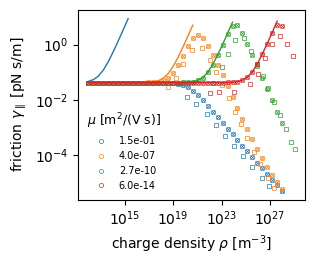

In [8]:
plt.figure(figsize=(3.25, 2.75))

for key, c in zip(Figure7b_sample1.keys(), ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']):
    
    x1 = Figure7b_sample1[key]['rho'].to('1/m^3').magnitude
    y1 = Figure7b_sample1[key]['gamma'].to('pN s/m').magnitude

    x2 = Figure7b_sample2[key]['rho'].to('1/m^3').magnitude
    y2 = Figure7b_sample2[key]['gamma'].to('pN s/m').magnitude
    
    x3 = Figure7b_original[key]['rho']
    y3 = Figure7b_original[key]['gamma']
    
    x4 = Figure7b_approx[key]['rho'].to('1/m^3').magnitude
    y4 = Figure7b_approx[key]['gamma'].to('pN s/m').magnitude
    
    plt.loglog(x1, y1, marker='o', markersize=3, fillstyle='none', linestyle='none', markeredgewidth=0.50, color=c, label=key)
    plt.loglog(x2, y2, marker='x', markersize=3, fillstyle='none', linestyle='none', markeredgewidth=0.50, color=c)
    plt.loglog(x3, y3, marker='s', markersize=3, fillstyle='none', linestyle='none', markeredgewidth=0.50, color=c)
    plt.loglog(x4, y4, linestyle='-', linewidth=1, color=c)

# plt.title('Lekkala 2013 Figure 7(b) Python')
plt.xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
plt.ylabel('friction $\gamma_{\parallel}$ [pN s/m]')
plt.legend(fontsize=7, loc=3, frameon=False, title='$\mu$ [m$^2$/(V s)]', title_fontsize=9)
plt.tight_layout()

plt.savefig(THIS + '--Fig-1.png', dpi=300)
plt.savefig(THIS + '--Fig-1.pdf')

plt.show()

**Figure caption**.  Lekkala 2013's Figure 7(b) simulations give identical results using sample1 with Method I (`o`) and sample2 with Method II (`x`'s) in a pure Python implimentation.  Friction was calculated versus charge density $\rho$ for four values the mobility $\mu$, indicated by color (legend). The calculated friction agrees with Lekkala (squares) at high density, and agrees with a Taylor expansion (solid lines) at low density, except at the highest mobility (blue line). 

# Run the simulations (`numba`-accelerated Python)

## Sample 1

In [9]:
sample1_jit = SampleModel1Jit(
    cantilever=CantileverModelJit(81.0e3, 3.,  80E-9, 300E-9),
    epsilon_s=complex(11.9,-0.05),
    h_s=3000E-9,
    mu=2.7E-10,
    rho=1e21,
    epsilon_d=complex(11.9,-0.05),
    z_r=300E-9)

In [10]:
sample1_jit.print()

cantilever
   cantilever freq =  81000.0 Hz
                   =  508938.0098815465 rad/s
tip-sample voltage =  3.0 V
            radius =  8e-08 m
            height =  3e-07 m

semiconductor
          epsilon (real) =  11.9
          epsilon (imag) =  -0.05
               thickness =  3e-06 m
                mobility =  2.7e-10 m^2/(V s)
      diffusion constant =  6.980039959763987e-12 m^2/s
          charge density =  1e+21 m^{{-3}}
        reference height =  3e-07 m
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  3.7033649406515185e-09 m
effective epsilon (real) =  11.9
effective epsilon (imag) =  -0.059599763628316975

dielectric
 epsilon (real) =  11.9
 epsilon (imag) =  -0.05
      thickness = infinite


Spot-check the integrand

In [11]:
theta1norm_jit(1, sample1_jit, 2)

-9.680112750074332e-05

## Sample 2

In [12]:
sample2_jit = SampleModel2Jit(
    cantilever=CantileverModelJit(81.0e3, 3.,  80E-9, 300E-9),
    epsilon_d=complex(11.9,-0.05),
    h_d=0.,
    epsilon_s=complex(11.9,-0.05),
    mu=2.7E-10,
    rho=1e21,
    z_r=300E-9)

In [13]:
sample2_jit.print()

cantilever
   cantilever freq =  81000.0 Hz
                   =  508938.0098815465 rad/s
tip-sample voltage =  3.0 V
            radius =  8e-08 m
            height =  3e-07 m

dielectric
 epsilon (real) =  11.9
 epsilon (imag) =  -0.05
      thickness =  0.0 m

semiconductor
          epsilon (real) =  11.9
          epsilon (imag) =  -0.05
               thickness = infinite
                mobility =  2.7e-10 m^2/(V s)
      diffusion constant =  6.980039959763987e-12 m^2/s
          charge density =  1e+21 m^{{-3}}
        reference height =  3e-07 m
            Debye length =  3.7797775481848936e-08 m
        diffusion length =  3.7033649406515185e-09 m
effective epsilon (real) =  11.9
effective epsilon (imag) =  -0.059599763628316975


Spot-check the integrand.

In [14]:
theta2norm_jit(1, sample2_jit, 2)

-9.680112753320861e-05

## Loop

In [15]:
rho1 = ureg.Quantity(np.logspace(start=12, stop=28, num=40), '1/m^3')

In [16]:
Figure7b_sample1_jit = {}
Figure7b_sample2_jit = {}

for mu_ in [0.15, 4e-7, 2.7e-10, 6e-14]:

    key = '{:0.1e}'.format(mu_)
    
    sample1_jit.mu = mu_
    sample2_jit.mu = mu_

    result1 = {
        'index': np.arange(len(rho1)),
        'rho': rho1,
        'gamma': ureg.Quantity(np.zeros_like(rho1), 'pN s/m')
    }
    
    result2 = {
        'index': np.arange(len(rho1)),
        'rho': rho1,
        'gamma': ureg.Quantity(np.zeros_like(rho1), 'pN s/m')
    }
    
    for index, rho_ in tqdm(enumerate(rho1)):

        sample1_jit.rho = rho_.to('1/m^3').magnitude
        sample2_jit.rho = rho_.to('1/m^3').magnitude
        
        result1['gamma'][index] = gamma_parallel_jit(theta1norm_jit, sample1_jit).to('pN s/m')
        result2['gamma'][index] = gamma_parallel_jit(theta2norm_jit, sample2_jit).to('pN s/m')

    Figure7b_sample1_jit[key] = result1
    Figure7b_sample2_jit[key] = result2

40it [00:00, 97.03it/s] 
40it [00:00, 175.40it/s]
40it [00:00, 163.47it/s]
40it [00:00, 159.40it/s]


## Plot

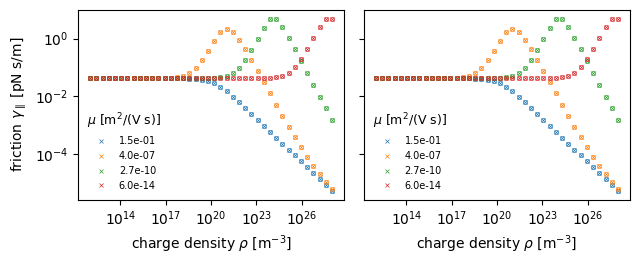

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(6.50, 2.75), sharey=True)

for key, c in zip(Figure7b_sample1_jit.keys(), ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']):
    
    x1 = Figure7b_sample1[key]['rho'].to('1/m^3').magnitude
    y1 = Figure7b_sample1[key]['gamma'].to('pN s/m').magnitude

    x2 = Figure7b_sample1_jit[key]['rho'].to('1/m^3').magnitude
    y2 = Figure7b_sample1_jit[key]['gamma'].to('pN s/m').magnitude

    x3 = Figure7b_sample2[key]['rho'].to('1/m^3').magnitude
    y3 = Figure7b_sample2[key]['gamma'].to('pN s/m').magnitude

    x4 = Figure7b_sample2_jit[key]['rho'].to('1/m^3').magnitude
    y4 = Figure7b_sample2_jit[key]['gamma'].to('pN s/m').magnitude
    
    axs[0].loglog(x1, y1, marker='o', markersize=3, fillstyle='none', linestyle='none', markeredgewidth=0.50, color=c)
    axs[0].loglog(x2, y2, marker='x', markersize=3, fillstyle='none', linestyle='none', markeredgewidth=0.50, color=c, label=key)
    axs[0].set_xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
    axs[0].set_ylabel('friction $\gamma_{\parallel}$ [pN s/m]')
    axs[0].legend(fontsize=7, loc=3, frameon=False, title='$\mu$ [m$^2$/(V s)]', title_fontsize=9)

    axs[1].loglog(x3, y3, marker='o', markersize=3, fillstyle='none', linestyle='none', markeredgewidth=0.50, color=c)
    axs[1].loglog(x4, y4, marker='x', markersize=3, fillstyle='none', linestyle='none', markeredgewidth=0.50, color=c, label=key)
    axs[1].set_xlabel(r'charge density $\rho$ [m$^{-3}$]')  # need a raw string here because \r is the special carriage return character
    axs[1].legend(fontsize=7, loc=3, frameon=False, title='$\mu$ [m$^2$/(V s)]', title_fontsize=9)

plt.tight_layout()

plt.savefig(THIS + '--Fig-2.png', dpi=300)
plt.savefig(THIS + '--Fig-2.pdf')

plt.show()

**Figure caption**.  Lekkala 2013's Figure 7(b) simulations give identical results using sample1 with Method I (left) and sample2 with Method II (right), in both a pure Python implimentation (circles) and a `numba` accelerated Python implimentation (squares).  Friction was calculated versus charge density $\rho$ for four values the mobility $\mu$, indicated by color (legend).

# Note on `numba`'s `np.tanh` bug.

`numba` has an ackowledged bug in its implimentation of `np.tanh`.  See the `numba` bug report "Inaccurate complex tanh implementation #2922" ([link](https://github.com/numba/numba/issues/2922)).  The following code reproduces the problem.

In [18]:
import numpy as np
from numba import jit, complex128

def f(a):
    return np.tanh(a)

print(f((1000-0j)))

@jit(complex128(complex128), nopython=True)
def g(a):
    return np.tanh(a)

print(g((1000-0j)))

(1+0j)
(nan+nanj)


The bug report suggests the following work-around.

In [19]:
import cmath

In [20]:
@jit(complex128(complex128), nopython=True)
def h(a):
    return cmath.tanh(a)

print(h((1000-0j)))

(1+0j)
